<a href="https://colab.research.google.com/github/NataliaKolesnik/Intergalactic_hackathon/blob/master/3_RZD_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Предсказание: Успеет ли произойти технологический процесс от изъятия вагона до включения в поезд в течении 36 часов вемени**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Импорт библиотек для обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score

In [3]:
# Загрузка данных из Наташиного csv файла

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RZD'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Датасет, полученный на этапе анализа, в которм отобраны только операции, удовлетворяющие нашим условиям
data = pd.read_csv(path + '/data_34.csv')

In [5]:
data

,станция,вагон,операция_первая,операция_последняя,все_операции,количество_операций,время_первой_операции,время_последней_операции,разница_времени,станция_назначения,опасный_груз,код_груза,род_вагона,вес_тары_вагона,изм_станции,длительность,длительность_час,ст_опер_кол_ваг,ранг_станции
0,830003,24579856,3,4,"[3, 80, 19, 81, 4, 3, 18, 4]",8,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003,0.0,0,20.0,NaN,0,2 days 11:24:00,59.400000,1155,4
1,830003,24622276,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003,0.0,0,20.0,NaN,0,1 days 04:55:00,28.916667,1155,4
2,830003,28034288,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-25 00:21:00,2020-07-28 05:40:00,3 days 05:19:00,830003,0.0,0,20.0,NaN,0,3 days 05:19:00,77.316667,1155,4
3,830003,28035723,3,4,"[3, 81, 4]",3,2020-07-23 16:57:00,2020-07-25 08:47:00,1 days 15:50:00,830003,0.0,0,20.0,NaN,0,1 days 15:50:00,39.833333,1155,4
4,830003,29019288,3,4,"[3, 18, 4]",3,2020-07-24 20:51:00,2020-07-28 02:00:00,3 days 05:09:00,830003,0.0,0,20.0,NaN,0,3 days 05:09:00,77.150000,1155,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333668,998100,61320917,3,4,"[3, 78, 20, 18, 79, 4]",6,2020-07-07 15:07:00,2020-07-12 01:30:00,4 days 10:23:00,998100,0.0,0,60.0,NaN,0,4 days 10:23:00,106.383333,95,2
333669,998100,62175377,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2
333670,998100,63750566,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2
333671,998100,66288432,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-25 05:24:00,2020-07-29 15:00:00,4 days 09:36:00,998100,0.0,0,60.0,NaN,0,4 days 09:36:00,105.600000,95,2


In [6]:
data['st_vag'] = data.apply(lambda row: (row.станция, row.вагон), axis=1)

Так как у нас бинарная классификация, то создаем целевую переменну. 

    1 - успеет за 36 часов
    0 - не успеет за 36 часов

In [7]:
data['присоединение_36ч'] = data['длительность_час'].apply(lambda x: 1 if x <= 36 else 0)

In [8]:
# длитеность в технол. процесса по количеству оперций
data['количество_операций'].max()

127

Максимальное количество операций 127, но при анализе мы выяснили, что до технологический процесс до 36 укладывается в 12 операций. Поэтому целесообразно взять чуть больше, например 20.

In [9]:
oper = data['все_операции'].values
i =  20  # Количество признаков - операций
for el in range(oper.shape[0]):
    x = oper[el].replace('[','').replace(']','').split(',')
    x = [int(j) for j in x]
    if len(x) >= i:
        oper[el] = np.array(x[:i])
    else:
        k0 = i - len(x)
        x=x+[0]*k0 
        oper[el] = np.array(x[:i])

In [10]:
proc = {}
col = ['col_'+str(i) for i in range(20)]
for el in range(len(col)):
    proc[col[el]] = [oper[i][el] for i in range(oper.shape[0])]


In [11]:
# Датасет технологических операции
df_tex_proc = pd.DataFrame(proc)

In [12]:
# Сформируем из ДатаСета выборку признаков
data_tr = data[['st_vag', 'ранг_станции', 'изм_станции', 'количество_операций', 'ст_опер_кол_ваг' ,'присоединение_36ч']].copy()

In [13]:
# Сконкотенируем два ДатаСета
data_tr = pd.concat([data_tr, df_tex_proc], axis=1)

In [14]:
# Получили готовый для обучения датасет
data_tr

,st_vag,ранг_станции,изм_станции,количество_операций,ст_опер_кол_ваг,присоединение_36ч,col_0,col_1,col_2,col_3,...,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19
0,"(830003, 24579856)",4,0,8,1155,0,3,80,19,81,...,0,0,0,0,0,0,0,0,0,0
1,"(830003, 24622276)",4,0,6,1155,1,3,80,28,19,...,0,0,0,0,0,0,0,0,0,0
2,"(830003, 28034288)",4,0,6,1155,0,3,80,28,19,...,0,0,0,0,0,0,0,0,0,0
3,"(830003, 28035723)",4,0,3,1155,0,3,81,4,0,...,0,0,0,0,0,0,0,0,0,0
4,"(830003, 29019288)",4,0,3,1155,0,3,18,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333668,"(998100, 61320917)",2,0,6,95,0,3,78,20,18,...,0,0,0,0,0,0,0,0,0,0
333669,"(998100, 62175377)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0
333670,"(998100, 63750566)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0
333671,"(998100, 66288432)",2,0,6,95,0,3,80,21,19,...,0,0,0,0,0,0,0,0,0,0


**Обучение**

In [15]:
def metrics(y_test, y_pred):
    """Комплексный расчет метрик"""
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred).round(4)
    recall = recall_score(y_test, y_pred).round(4)
    roc_auc = roc_auc_score(y_test, y_pred).round(4)
    f1 = f1_score(y_test, y_pred).round(4)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Если необходимо вывести метрики на печать - раскомментировать
    print('Матрица:')
    print(conf_matrix)
    print('точность (precision) - ', precision)
    print('полнота (recall) -', recall)
    print('roc_auc - ', roc_auc)
    print('f1_score - ', f1)
    print('accuracy - ', accuracy)

    
    #return {'conf_matrix': conf_matrix, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc, 'f1': f1}

In [16]:
RANDOM_STATE = 42

In [17]:
# Разбиваем на признаки и целевую переменную
X = data_tr.drop(['st_vag', 'присоединение_36ч'], axis=1)
Y = data_tr['присоединение_36ч']


In [18]:
# Разобъем нашу выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=Y)

In [19]:
# Разделим X_train на тестовую и валидационную выборки
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train, test_size=0.2, random_state=RANDOM_STATE, shuffle=True, stratify=Y_train)

**RandomForestClassifier**

In [20]:
# Для таких признаков лучше всего подойдет модель Смешанный лес. 
# Так как Смешаннй лес не чуствительный к разному масштабу данных, то коллебровать данные не будем.

In [21]:
clf_RFC = RandomForestClassifier(n_estimators=15, random_state=RANDOM_STATE)
clf_RFC = clf_RFC.fit(X_train, Y_train)
Y_pred = clf_RFC.predict(X_test)
metrics(Y_test, Y_pred)

Матрица:
[[42187  4755]
 [ 4733 15060]]
точность (precision) -  0.76
полнота (recall) - 0.7609
roc_auc -  0.8298
f1_score -  0.7605
accuracy -  0.8578257286281561


**Метрики качества:**

Точность и полнота получились сбалансированными между собой и составляют по 76%.  
Что так же видно и по матрице ошиок.

accuracy (доляверных ответов) - 86%

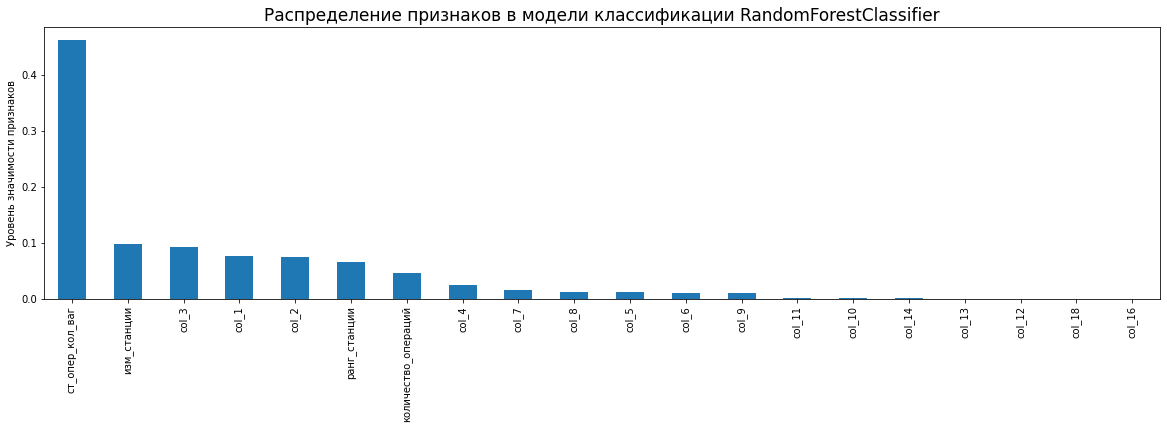

In [22]:
RF_feaches = pd.Series(clf_RFC.feature_importances_)
RF_feaches.index = X.columns
RF_feaches = RF_feaches.sort_values(ascending=False)

RF_feaches[:i].plot.bar(figsize=(20,5))
plt.ylabel('Уровень значимости признаков')
plt.title('Распределение признаков в модели классификации RandomForestClassifier', fontsize = 17)
plt.show()

**Наиболее важными признаками модель определила:**
1. Пропускная способность станции (сколько она обслужила вагонов в месяце)
2. Конечная эта или транзитная станция
3. Первые операции технологического процесса (1-4)
4. Ранг станции - это распределение станций по группам, в зависимости от пропускной способности
5. Количество операций технологического процесса над вагоном 

Эти же признаки нами выявили и в результате анализа данных.



In [23]:
# Считает долго - без нужды не запускать
# # Подбор гиперпараметров
# n_estimators = [10, 25, 40, 60,75]
# max_features = [4,6,8,10]
# max_depth = [2,3,7,11,15]
# min_samples_split = [2,3,4,22,23,24]
# min_samples_leaf = [2,3,4,5,6,7]
# bootstrap = [False]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# gs = GridSearchCV(clf_RFC, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_valid, Y_valid)
# clf_RFC = gs.best_estimator_
# gs.best_params_

In [24]:
clf_RFC_bp = RandomForestClassifier(n_estimators=60, 
                                    bootstrap=False,
                                    max_depth=15,
                                    max_features=10,
                                    min_samples_leaf=2,
                                    min_samples_split=2,
                                    random_state=RANDOM_STATE)
clf_RFC_bp = clf_RFC_bp.fit(X_train, Y_train)
Y_pred = clf_RFC_bp.predict(X_test)
metrics(Y_test, Y_pred)

Матрица:
[[43210  3732]
 [ 6388 13405]]
точность (precision) -  0.7822
полнота (recall) - 0.6773
roc_auc -  0.7989
f1_score -  0.726
accuracy -  0.8483554356784296


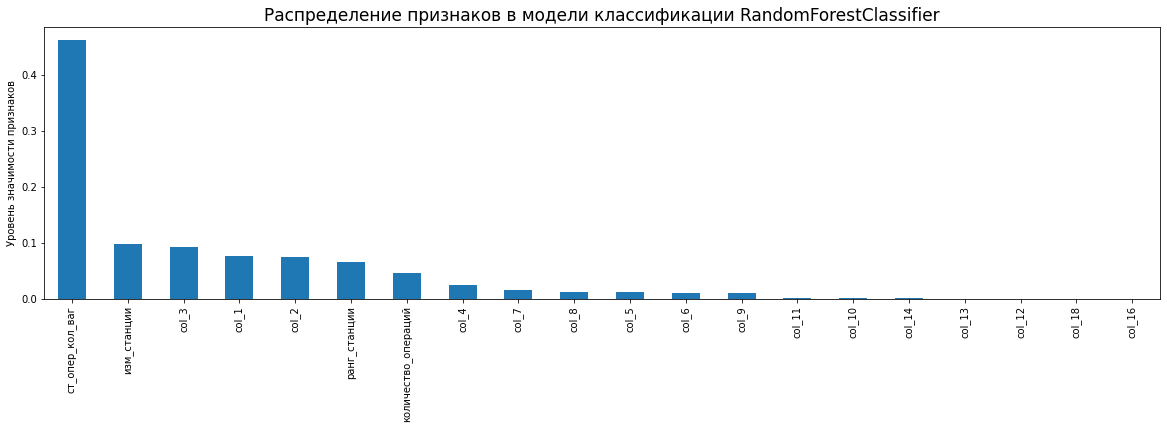

In [25]:
RF_feaches = pd.Series(clf_RFC.feature_importances_)
RF_feaches.index = X.columns
RF_feaches = RF_feaches.sort_values(ascending=False)

RF_feaches[:i].plot.bar(figsize=(20,5))
plt.ylabel('Уровень значимости признаков')
plt.title('Распределение признаков в модели классификации RandomForestClassifier', fontsize = 17)
plt.show()

Гиперпараметры картину не изменили, а даже ухудшили по многим метрикам. Распределение признаков осталось прежнем. Оставим базовую модель

